# JOLLY Preprocessing Scripts
by MG Malana and Jerelyn Co

General tasks:
- [x] collate labeled files in one dataframe
- [x] collate and preprocess (if necessary) test scores
- [ ] provide basic quali and quanti analyses

Subtasks:
- [x] histogram of final vote classes (overall and per university)
- [ ] normalized histogram of final vote classes (per university) 
- [x] box plot of test scores per university
- [x] interrator score

To check
- dapat walang "VOTE" under final act
- delete other columns

In [1]:
# Importing packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import glob
%pylab inline
sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_dir = 'data/'
data_raw_dir = data_dir +'raw/'
data_proc_dir = data_dir +'proc/'

data_raw_label_dir = data_raw_dir + 'label/'
data_raw_score_dir = data_raw_dir + 'scores/'

# Labelled Dataset

Contains the chat logs between the pair programmer, translation to English language, votes of each voter, final vote for cases of conflict, and timestamp.

## Collation and preliminary preprocessing

In [3]:
# merge all excels into 1 data frame
label_df = pd.DataFrame()
column_names = ['text', 'person', 'translation', 'a1', 'a2', 'match', 'final_act', 'timestamp', 'school', 'filename', 'student']
column_name_change = {'TEXT': 'text', 'ORIGINAL TEXT/CONVO': 'text', 'Original text': 'text', 'PERSON': 'person',
                      'TRANSLATION': 'translation', 'A1': 'a1',
                      'A2': 'a2', 'Match': 'match', 'MATCH': 'match',
                      'FINAL': 'final_act', 'Final Act': 'final_act', 'Timestamp': 'timestamp', 'Student': 'student'}

In [4]:
# iterate folders
for folder in glob.iglob(data_raw_label_dir + '*/'):
    for filename in glob.iglob(folder +'*.xlsx'):
        school_name = folder.replace(data_raw_label_dir, '').replace('/', '')
        filename = filename.replace(folder, '')
        temp_df = pd.read_excel(data_raw_label_dir + school_name + '/' + filename)
        temp_df = temp_df.rename(columns= column_name_change)

        # add additional columns
        temp_df['school'] = school_name
        temp_df['filename'] = filename
        
        # setting timestamp and student
        if not temp_df.index.is_integer():
            index_split = list(temp_df.index.str.split(':', 1))           
            temp_df['timestamp'] = np.array(index_split)[:,1]
            temp_df['student'] = np.array(index_split)[:,0]
        else: 
            temp_df.index = temp_df['student'] + ":" + temp_df['timestamp'].astype(str)

        # remove extra columns
        temp_df = temp_df.drop(set(temp_df.columns) - set(column_names), axis=1)
#          temp_df = temp_df.loc[:, ~temp_df.columns.str.contains('^Unnamed')] # remove unnamed columns     
        
        # error checking on data
        if not set(column_names).issubset(temp_df.columns):                # check if incomplete columns
            raise Exception('Column names in ' + filename + ' are incomplete')
        if not set(temp_df.columns).issubset(column_names):                # check if has extra columns
            raise Exception('There are extra column names in ' + filename)
        if temp_df['final_act'].isnull().any():                            # check if final act has null
            raise Exception('Null final act in ' + filename)
        if temp_df['final_act'].str.match('VOTE').any():                   # check if final act has 'VOTE' value
            raise Exception('Invalid final act in ' + filename)
    
        label_df = label_df.append(temp_df)

label_df.head()

,a1,a2,filename,final_act,match,person,school,student,text,timestamp,translation
UC-DP01B:13:11:59,InfSoc,InfSoc,UC-DP01A-DP01B.xlsx,InfSoc,True,B,UC,UC-DP01B,hello,13:11:59,hello
UC-DP01A:13:12:01,InfStm,InfStm,UC-DP01A-DP01B.xlsx,InfStm,True,A,UC,UC-DP01A,test,13:12:01,test
UC-DP01B:13:12:06,ResCfm,ResCfm,UC-DP01A-DP01B.xlsx,ResCfm,True,B,UC,UC-DP01B,okay,13:12:06,okay
UC-DP01A:13:12:34,InfNeg,InfNeg,UC-DP01A-DP01B.xlsx,InfNeg,True,A,UC,UC-DP01A,im not good in programming,13:12:34,im not good in programming
UC-DP01B:13:13:29,InfNeg,InfNeg,UC-DP01A-DP01B.xlsx,InfNeg,True,B,UC,UC-DP01B,i dont even know what to do,13:13:29,i dont even know what to do


In [5]:
label_df.index.name='index'
label_df.to_csv(data_proc_dir + 'labelled_data.csv')

## Preliminary EDA

In [6]:
# Loading dataset
label_df = pd.read_csv(data_proc_dir + 'labelled_data.csv', index_col='index')

# Selecting three schools for now: ADMU, ADDU, ADNU
label_df = label_df[label_df["school"].isin(["ADMU", "ADNU", "ADDU"])]

==== Per School count ====
ADMU    2752
ADNU    2111
ADDU    1960
Name: school, dtype: int64
==== Total number of lines ====
6823


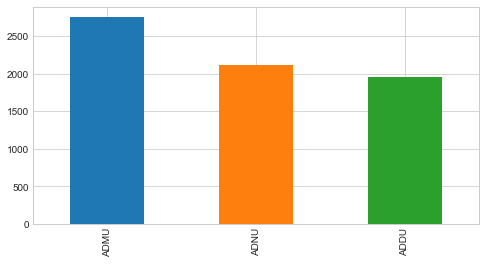

In [7]:
# Showing value counts (number of lines) per school
plt.figure(figsize=(8,4))
label_df["school"].value_counts().plot(kind="bar")

# Showing the numbers

print("==== Per School count ====")
print(label_df["school"].value_counts())
print("==== Total number of lines ====")
total_size = len(label_df)
print(total_size)

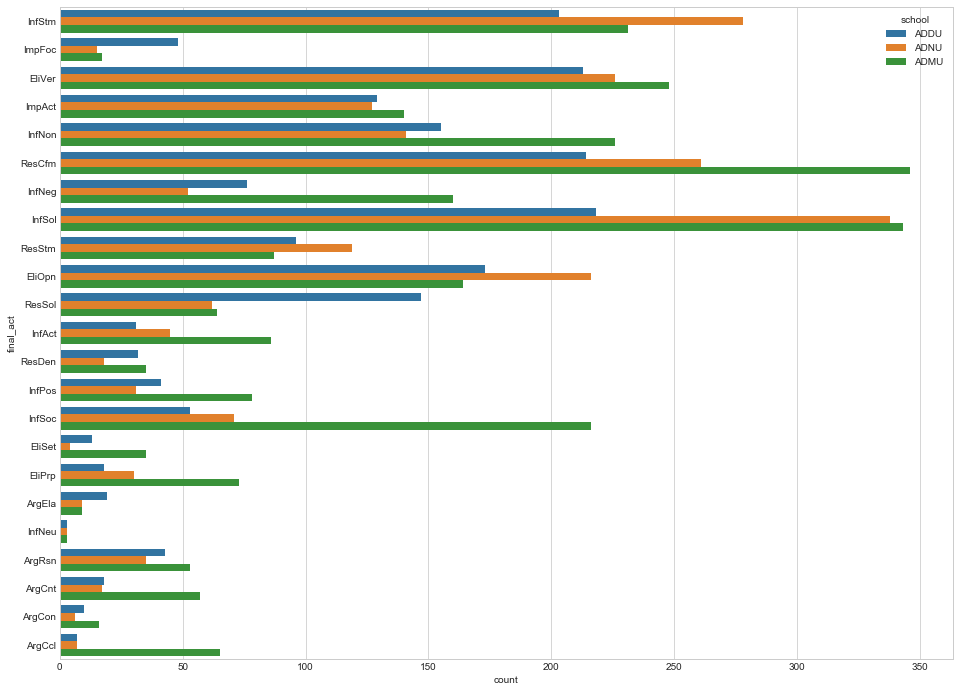

In [8]:
# Showing breakdown of votes per class
plt.figure(figsize=(16,12))
sns.countplot(y="final_act", hue="school", data=label_df)

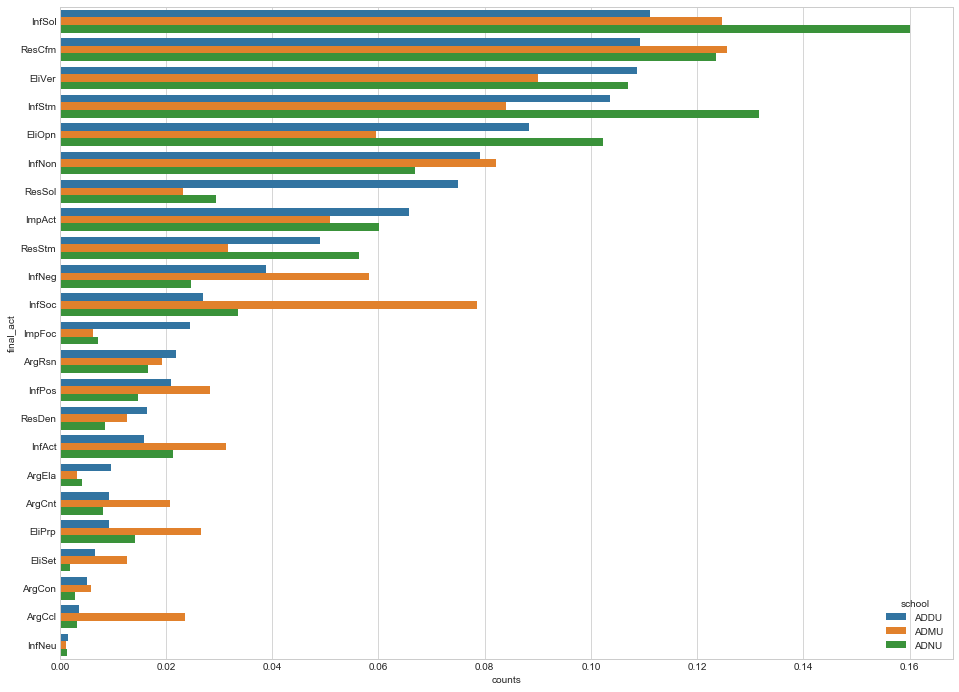

In [87]:
# Showing normalized breakdown of votes per class

label_norm_df = label_df.groupby(['school'])['final_act'].value_counts(True).reset_index(name='counts')

plt.figure(figsize=(16,12))
sns.barplot(x="counts", y="final_act", hue="school", data=label_norm_df)

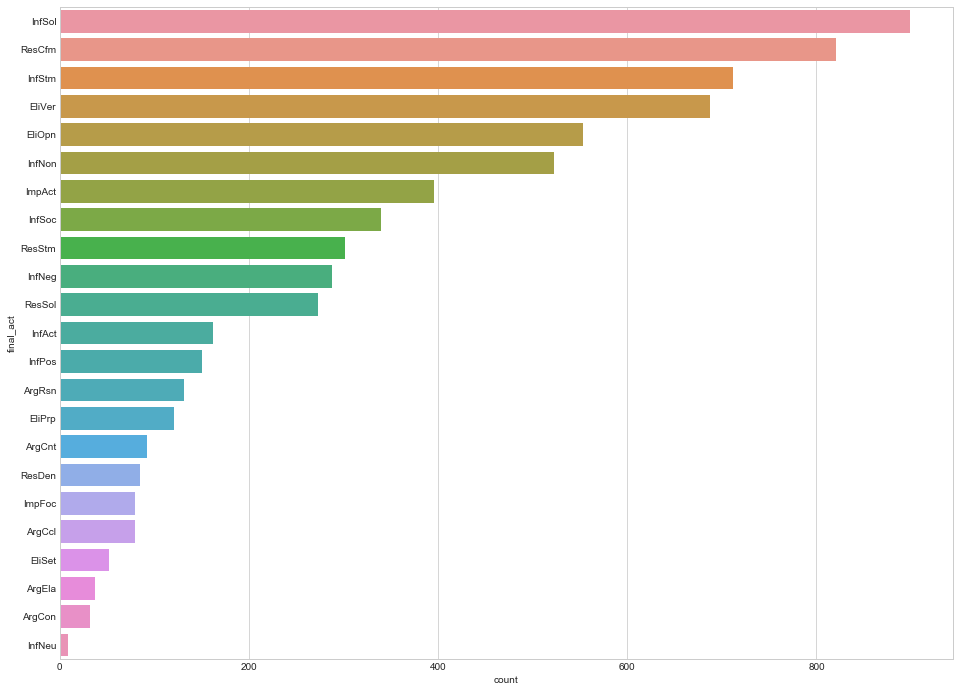

In [14]:
plt.figure(figsize=(16,12))
sns.countplot(y="final_act", data=label_df, order = label_df['final_act'].value_counts().index)

In [10]:
# Rater Scores
print("==== Rater scores ====")
a1_rating = print("A1: {}%".format(len(label_df[label_df['a1'] == label_df['final_act']]) * 100/total_size))
a2_rating = print("A2: {}%".format(len(label_df[label_df['a2'] == label_df['final_act']]) * 100/total_size))

==== Rater scores ====
A1: 95.47120035175143%
A2: 89.94577165469735%


# Scores Dataset

In [11]:
# read and clean dataset
scores_df = pd.read_excel(data_raw_score_dir + 'all scores.xlsx')
scores_df = scores_df.dropna()
scores_df = scores_df.rename(columns= {'Student ID': 'student', 'School': 'school', 'Static / Dynamic': 'static_or_dynamic',
                                      'Individual / Pair': 'individual_or_pair', 'Gender': 'gender',
                                      'Pre-test score': 'pre_test_score', 'Self-efficacy': 'self_efficacy',
                                      'Debugging scores': 'debugging_scores'})

scores_df.head()

,student,school,static_or_dynamic,individual_or_pair,gender,pre_test_score,self_efficacy,debugging_scores
0,ADDU-DP02A,ADDU,Dynamic,Pair,F,6.0,4.88,13.0
1,ADDU-DP02B,ADDU,Dynamic,Pair,F,4.0,4.32,13.0
2,ADDU-DP03B,ADDU,Dynamic,Pair,F,4.0,3.53,10.0
3,ADDU-DP07B,ADDU,Dynamic,Pair,F,7.0,3.74,18.0
4,ADDU-SP02A,ADDU,Static,Pair,F,7.0,5.69,14.5


In [12]:
scores_df.to_csv(data_proc_dir + 'scores.csv')

## Preliminary EDA

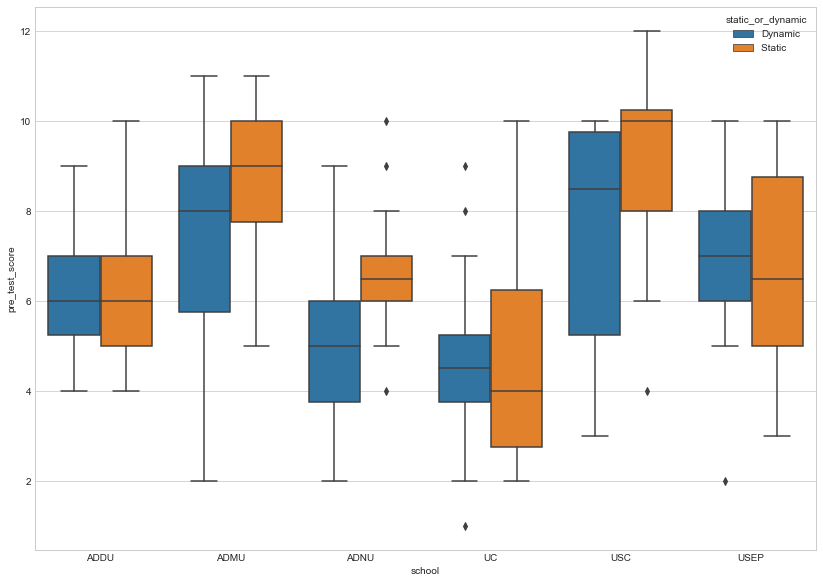

In [13]:
plt.figure(figsize=(14,10))
sns.boxplot(x="school", hue="static_or_dynamic", y="pre_test_score", data=scores_df)